- We decided not to analyze Biomarkers B due to imbalanced target distribution and small dataset size.
- We deicided to analyze ***combined*** target only.
- 
- I want to get feature importances with RFimportance, SHAP, and SFS/RFE
- 

## Prerequisites

### Import libraries

In [2]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
# from google.colab import output

from pandas import DatetimeIndex as dt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# from google.colab import files
import IPython
from IPython.display import HTML, display, clear_output 
# from google.colab import drive
import sys

# hyper-parameters optimisation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# metrics
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as TP_rate                          
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score as recall
from sklearn.metrics import average_precision_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer,fbeta_score
from sklearn.model_selection import StratifiedKFold


# classifiers
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostRegressor, RandomForestRegressor, GradientBoostingClassifier, StackingClassifier, VotingClassifier #
from sklearn.tree import DecisionTreeClassifier     #
from sklearn.svm import SVC                                    # both linear and radial classification
from sklearn.neighbors import KNeighborsClassifier             # k=3
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import catboost
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from mlxtend.classifier import StackingClassifier

# statistics
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

# imputations
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

# feature selection
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif, SelectKBest, RFE, RFECV, SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import kendalltau, spearmanr
from sklearn.linear_model import Lasso
from sklearn.model_selection import StratifiedKFold
from mrmr import mrmr_classif
from yellowbrick.features import RFECV as RFECV_visual
import shap

from tqdm.auto import tqdm

# to conver string to dict
import ast

# Interpretability
 # !pip install interpret
from interpret.blackbox import LimeTabular
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show

import lime
import lime.lime_tabular
from __future__ import print_function

# ignore warnings when graphs are plotted
import warnings
warnings.filterwarnings('ignore')

### Data import

In [3]:
# links to datasets

# lancet

link_train_lancet = './HSE project/Preprocessed Data/lancet dataset/train_abc_lancet.xlsx'
link_test_lancet  = './HSE project/Preprocessed Data/lancet dataset/test_abc_lancet.xlsx'

# death
link_train_death_a   = './HSE project/Preprocessed Data/cardiovascular death/train_a.xlsx'
link_test_death_a    = './HSE project/Preprocessed Data/cardiovascular death/test_a.xlsx'
link_train_death_b   = './HSE project/Preprocessed Data/cardiovascular death/train_b.xlsx'
link_test_death_b    = './HSE project/Preprocessed Data/cardiovascular death/test_b.xlsx'
link_train_death_c   = './HSE project/Preprocessed Data/cardiovascular death/train_c.xlsx'
link_test_death_c    = './HSE project/Preprocessed Data/cardiovascular death/test_c.xlsx'
link_train_death_abc = './HSE project/Preprocessed Data/cardiovascular death/train_abc.xlsx'
link_test_death_abc  = './HSE project/Preprocessed Data/cardiovascular death/test_abc.xlsx'

# combined
link_train_combined_a   = './HSE project/Preprocessed Data/combined/train_a.xlsx'
link_test_combined_a    = './HSE project/Preprocessed Data/combined/test_a.xlsx'
link_train_combined_b   = './HSE project/Preprocessed Data/combined/train_b.xlsx'
link_test_combined_b    = './HSE project/Preprocessed Data/combined/test_b.xlsx'
link_train_combined_c   = './HSE project/Preprocessed Data/combined/train_c.xlsx'
link_test_combined_c    = './HSE project/Preprocessed Data/combined/test_c.xlsx'
link_train_combined_abc = './HSE project/Preprocessed Data/combined/train_abc.xlsx'
link_test_combined_abc  = './HSE project/Preprocessed Data/combined/test_abc.xlsx'

# revascularization
link_train_revascularization_a   = './HSE project/Preprocessed Data/revascularization/train_a.xlsx'
link_test_revascularization_a    = './HSE project/Preprocessed Data/revascularization/test_a.xlsx'
link_train_revascularization_b   = './HSE project/Preprocessed Data/revascularization/train_b.xlsx'
link_test_revascularization_b    = './HSE project/Preprocessed Data/revascularization/test_b.xlsx'
link_train_revascularization_c   = './HSE project/Preprocessed Data/revascularization/train_c.xlsx'
link_test_revascularization_c    = './HSE project/Preprocessed Data/revascularization/test_c.xlsx'
link_train_revascularization_abc = './HSE project/Preprocessed Data/revascularization/train_abc.xlsx'
link_test_revascularization_abc  = './HSE project/Preprocessed Data/revascularization/test_abc.xlsx'

### Tuning of hyper-parameters

#### Grids of hyper-parameters

In [4]:
# hyper-parameters for gridsearchCV

# 1. Logistic regression
parameters_LR_model = dict(
                          C = [0.001, 0.01, 0.1, 1.],  # defeult
                          tol = [1.e-4],
                          penalty = ['l2', 'none'], #'elasticnet', 'l1', 
                          # njobs = [-1],
                          dual = [False],
                          fit_intercept = [False],
                          # intercept_scaling =
                          class_weight = ['balanced', None],
                          random_state = [10],
                          # solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                          max_iter = [10000],
                          multi_class = ['auto'],
                          verbose = [0],
                          warm_start = [True]
                          # l1_ratio
                          )

# 2. Random Forest
parameters_random_forest_model = dict(
                  n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 10)],
                  criterion = ['gini'],
                  max_depth = [*[int(x) for x in np.linspace(2, 10, num = 5)]],
                  min_samples_split = [2,4],  
                  # min_samples_leaf = [1,2],  
                  min_weight_fraction_leaf = [0.0],
                  max_features = ['sqrt'],  
                  max_leaf_nodes = [None],
                  min_impurity_decrease = [0.],
                  bootstrap = [True],
                  oob_score = [False],
                  n_jobs = [-1],
                  random_state = [10],
                  verbose = [0],
                  warm_start = [True],
                  class_weight = ['balanced', 'balanced_subsample', None],
                  # ccp_alpha = 
                  max_samples = [None]  # maybe =0.1 here for getting almost independent samples for trees
                  )

# 3. k-NN
parameters_knn = dict(
                      n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 7, num = 7)],
                      weights = ['uniform', 'distance'],
                      algorithm = ['ball_tree', 'kd_tree', 'brute'], 
                      leaf_size = [15, 30, 60],
                      p = [3], 
                      metric = ['chebyshev', 'minkowski', 'euclidean', 'manhattan'],
                      # metric_params = 
                      n_jobs = [-1]
                      )

# 4. SVM
parameters_svm = dict(
                  C = [int(x) for x in np.linspace(start = 1, stop = 25, num = 7)],
                  kernel = ['rbf', 'linear', 'poly', 'sigmoid'],
                  degree = [3, 4, 5],
                  gamma = ['scale', 'auto'],
                  coef0 = [0.0],
                  shrinking = [True, False],
                  probability = [True],
                  tol = [1.e-3], 
                  cache_size = [200],
                  class_weight = ['balanced', None],
                  verbose = [False],
                  max_iter = [1.e6],  # мб поставить конечные итерации, как в Logistic Regression
                  # decision_function_shape = [],
                  # break_ties = [],
                  random_state = [10]
                  )

# 5. CatBoost
catboost_parameters = {'depth': [4,6,8,10],  # larger depth is preferable
              'learning_rate': [0.1,0.2,0.3],
              # 'l2_leaf_reg': [0,3,6,1],
              }
c_boost_params = {'eval_metric' : 'F1', # 'F1' my_f2_scorer, 'F'
                  # 'beta' : 2,
                  'verbose' : False,
                  'early_stopping_rounds' : 100,
                  #cat_features=cat_features,
                  'task_type' : "CPU",
                  'iterations' : 500,
                  'random_seed' : 10}

#### Function: Optimised table of metrics 

In [5]:
def optimised_metrics_table(model_name):
    optimised_metrics = []
    # optimised_metrics.append(mcc(y_test, forecast))        #.round(3)                          # MCC
    optimised_metrics.append(f1(y_test, forecast).round(3))                                    # F1
    optimised_metrics.append(f2_func(y_test, forecast).round(3))                               # F2
    optimised_metrics.append(accuracy(y_test, forecast).round(3))                              # Accuracy
    optimised_metrics.append(TP_rate(y_test, forecast).round(3))                               # TP rate
    optimised_metrics.append(recall(y_test, forecast).round(3))                                # TN rate
    precision, recall_, thresholds = precision_recall_curve(y_test, forecast_proba)                  # ------
    optimised_metrics.append(auc(recall_, precision).round(3))                                 # PR AUC
    optimised_metrics.append(roc_auc(y_test, forecast_proba).round(3))                               # ROC AUC
    optimised_metrics.append(confusion_matrix(y_test, forecast).ravel()[0])                    # number of true negative
    optimised_metrics.append(confusion_matrix(y_test, forecast).ravel()[1])                    # number of false positive
    optimised_metrics.append(confusion_matrix(y_test, forecast).ravel()[2])                    # number of false negative
    optimised_metrics.append(confusion_matrix(y_test, forecast).ravel()[3])                    # number of true positive

    optimised_metrics = pd.DataFrame(optimised_metrics, columns=[model_name])
    # add rows names
    optimised_metrics.index = [
                              #  "MCC",
                               "F1", "F2",
                               "Accuracy",
                               "Precision",
                               "Recall",
                               "PR_AUC",
                               "ROC_AUC",
                               "TN", "FP", "FN", "TP"
                                ]
    optimised_metrics = optimised_metrics.T
    
    return optimised_metrics

#### Function metric_table - visualise model scores

In [6]:
# '''
# This function provides scores for gridsearch F1-score and metrics for test dataset
# '''

# def metric_table(path):  #, X_train=X_train, y_train=y_train

#     # read gridsearch tables
#     randomforest_optimisation = pd.read_excel(f'{path}randomforest_optimisation.xlsx', header=[0]) #/content/  ./imp_feat
#     svm_optimisation = pd.read_excel(f'{path}svm_optimisation.xlsx', header=[0])
#     knn_optimisation = pd.read_excel(f'{path}knn_optimisation.xlsx', header=[0])
#     LogisticRegression_optimisation = pd.read_excel(f'{path}LogisticRegression_optimisation.xlsx', header=[0])
#     catboost_optimisation = pd.read_excel(f'{path}catboost_optimisation.xlsx', header=[0])

#     params = randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["params"]].iloc[0]
#     params = ast.literal_eval(params[0])
#     random_forest_model = RandomForestClassifier(**params)
#     # 
#     params = svm_optimisation[svm_optimisation['rank_test_score']==1][["params"]].iloc[0]
#     params = ast.literal_eval(params[0])
#     SVM_model = SVC(**params)
#     # 
#     # params = nn_optimisation[nn_optimisation['rank_test_score']==1][["params"]].iloc[0]
#     # params = ast.literal_eval(params[0])
#     # newral_network_model = MLPClassifier(**params)
#     # 
#     params = knn_optimisation[knn_optimisation['rank_test_score']==1][["params"]].iloc[0]
#     params = ast.literal_eval(params[0])
#     knn_model = KNeighborsClassifier(**params)
#     # 
#     params = LogisticRegression_optimisation[LogisticRegression_optimisation['rank_test_score']==1][["params"]].iloc[0]
#     params = ast.literal_eval(params[0])
#     LR_model = LogisticRegression(**params)
#     # 
#     params = catboost_optimisation['params'][0]
#     params = ast.literal_eval(params)
#     catboost_model = CatBoostClassifier(**c_boost_params, **params)

#     models = [
#     random_forest_model,
#     SVM_model,
#     # newral_network_model,
#     LR_model,
#     knn_model,
#     catboost_model
#     ]

#     mcc_score, f1_score,f2_score, accuracy_score, TP_rate_score, recall_score, auc_precision_recall, roc_auc_score= [], [], [], [], [], [], [], []
#     tn, fp, fn, tp = [], [], [], []

#     for model in models:
#         model.fit(X_train, y_train)
#         forecast = model.predict(X_test)
#         forecast_proba = model.predict_proba(X_test)

#         # mcc_score.append(mcc(y_test, forecast))                                   # MCC
#         f1_score.append(f1(y_test, forecast))                                       # F1
#         f2_score.append(f2_func(y_test, forecast))                                  # F1
#         accuracy_score.append(accuracy(y_test, forecast))                           # Accuracy  
#         TP_rate_score.append(TP_rate(y_test, forecast))                             # TP rate   tp / (tp + fp)
#         recall_score.append(recall(y_test, forecast))                               # TN rate
#         auc_precision_recall.append(average_precision_score(y_test, forecast_proba[:,1]))      # PR AUC
#         roc_auc_score.append(roc_auc(y_test, forecast_proba[:,1]))                       # ROC AUC
#         tn.append(confusion_matrix(y_test, forecast).ravel()[0])                  # number of true negative
#         fp.append(confusion_matrix(y_test, forecast).ravel()[1])                  # number of false positive
#         fn.append(confusion_matrix(y_test, forecast).ravel()[2])                  # number of false negative
#         tp.append(confusion_matrix(y_test, forecast).ravel()[3])                  # number of true positive

#     # create matrix table 
#     metrics_table = pd.DataFrame(columns=pd.MultiIndex.from_product([["F2, train set, cv=5"],["mean", 'std']]))
#     # metrics_table[("Scores on the test set","MCC")] = mcc_score
#     metrics_table[("Scores on the test set","F1")] = f1_score
#     metrics_table[("Scores on the test set","F2")] = f2_score
#     metrics_table[("Scores on the test set","Accuracy")] = accuracy_score
#     metrics_table[("Scores on the test set","Precision")] = TP_rate_score
#     metrics_table[("Scores on the test set","Recall")] = recall_score
#     metrics_table[("Scores on the test set","PR_AUC")] = auc_precision_recall
#     metrics_table[("Scores on the test set","ROC_AUC")] = roc_auc_score
#     metrics_table[("Confusion matrix","TN")] = tn
#     metrics_table[("Confusion matrix","FP")] = fp
#     metrics_table[("Confusion matrix","FN")] = fn
#     metrics_table[("Confusion matrix","TP")] = tp

#     # modify the rows names
#     metrics_table.index = [
#                 "Random Forest",
#                 "SVM",
#                 # "Multi-layer Perceptron",
#                 "Logistic Regression",
#                 "KNN",
#                 "CatBoost"
#                 ]



#     # add cross validated F2 scores on the train set
#     mean = []
#     std = []
#     mean_test_f1,std_test_f1 = randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
#     randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
#     mean.append(mean_test_f1); std.append(std_test_f1)
#     mean_test_f1,std_test_f1 = svm_optimisation[svm_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
#     mean.append(mean_test_f1); std.append(std_test_f1)
#     # mean_test_f1,std_test_f1 = nn_optimisation[nn_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
#     # mean.append(mean_test_f1); std.append(std_test_f1)
#     mean_test_f1,std_test_f1 = LogisticRegression_optimisation[LogisticRegression_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
#     mean.append(mean_test_f1); std.append(std_test_f1)
#     mean_test_f1,std_test_f1 = knn_optimisation[knn_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
#     mean.append(mean_test_f1); std.append(std_test_f1)
#     mean_test_f1,std_test_f1 = catboost_optimisation[['test-F:beta=1-mean', 'test-F:beta=1-std']].iloc[catboost_optimisation.shape[0]-1]
#     mean.append(mean_test_f1); std.append(std_test_f1)
    

#     metrics_table[("F2, train set, cv=5","mean")] = mean
#     metrics_table[("F2, train set, cv=5","std")] = std

#     # add cross validated F2 scores on the train set
#     mean_roc_auc = []
#     std_roc_auc = []
#     mean_test_roc_auc,std_test_roc_auc = randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
#     randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
#     mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
#     mean_test_roc_auc,std_test_roc_auc = svm_optimisation[svm_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
#     mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
#     # mean_test_roc_auc,std_test_roc_auc = nn_optimisation[nn_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
#     # mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
#     mean_test_roc_auc,std_test_roc_auc = LogisticRegression_optimisation[LogisticRegression_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
#     mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
#     mean_test_roc_auc,std_test_roc_auc = knn_optimisation[knn_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
#     mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
#     mean_test_roc_auc,std_test_roc_auc = catboost_optimisation[["roc_auc_mean","roc_auc_std"]].iloc[catboost_optimisation.shape[0]-1]
#     mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)

#     metrics_table[("ROC_AUC, train set, cv=5","mean")] = mean_roc_auc
#     metrics_table[("ROC_AUC, train set, cv=5","std")] = std_roc_auc

#     return metrics_table

#### Define $F_2$ metric

In [7]:
def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2.)
    return f2_score

def my_f2_scorer():
    return make_scorer(f2_func)

## Feature selection

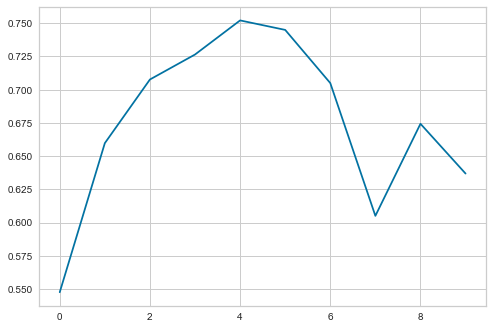

In [140]:
# f1
plt.plot([sfs.subsets_[i]['avg_score'] for i in list(sfs.subsets_)])
# ("('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE, баллы')",
#    "('БИОМАРКЕРЫ', 'PCSK9 (нг/мл)')",
#    "('ИСХОДНАЯ ЭХОКГ', 'иММ ЛЖ')",
#    "('ЛАБОРАТОРНЫЕ ПОКАЗАТЕЛИ', 'ЛПВП, ммоль/л')",
#    "('БИОМАРКЕРЫ', 'MMP-9 (нг/мл)')

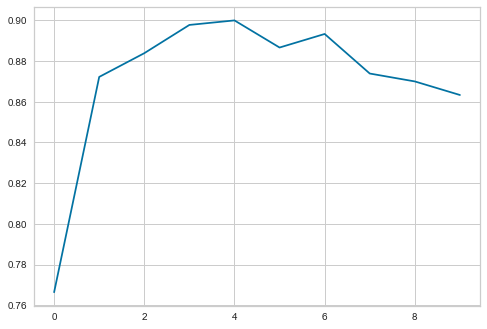

In [143]:
# roc_auc
plt.plot([sfs.subsets_[i]['avg_score'] for i in list(sfs.subsets_)], )
# ("('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE, баллы')",
  #  "('БИОМАРКЕРЫ', 'PCSK9 (нг/мл)')",
  #  "('АНТРОПОФИЗИОМЕТРИЯ', 'Возраст')",
  #  "('ИСХОДНАЯ ЭХОКГ', 'иКСО ЛЖ')")

In [141]:
sfs.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([0.66666667, 0.57142857, 0.33333333, 0.5       , 0.66666667]),
  'avg_score': 0.5476190476190477,
  'feature_names': ("('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE, баллы')",)},
 2: {'feature_idx': (0, 3),
  'cv_scores': array([0.72727273, 0.66666667, 0.44444444, 0.57142857, 0.88888889]),
  'avg_score': 0.6597402597402596,
  'feature_names': ("('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE, баллы')",
   "('БИОМАРКЕРЫ', 'PCSK9 (нг/мл)')")},
 3: {'feature_idx': (0, 3, 7),
  'cv_scores': array([0.83333333, 0.8       , 0.44444444, 0.57142857, 0.88888889]),
  'avg_score': 0.7076190476190477,
  'feature_names': ("('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE, баллы')",
   "('БИОМАРКЕРЫ', 'PCSK9 (нг/мл)')",
   "('ИСХОДНАЯ ЭХОКГ', 'ПЖ')")},
 4: {'feature_idx': (0, 2, 3, 7),
  'cv_scores': array([1.        , 0.72727273, 0.44444444, 0.57142857, 0.88888889]),
  'avg_score': 0.7264069264069264,
  'feature_names': ("('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE, баллы')",
   "('АНТРОПОФИЗИОМЕТРИ

In [136]:
top = list(pd.read_excel(f'./HSE project/Feature selection/combined/Biomarkers + Clinical C/SHAP/randomforest_values.xlsx', header=[0], index_col=[0]).sort_values(by='values', ascending=False)['features'][:10].values)
# top 

In [137]:
X_train, X_test, y_train, y_test = z.get_train_test(link_train=link_train_combined_c, link_test=link_test_combined_c, dataset='c', subset='Biomarkers + Clinical')

In [138]:
X_train = X_train[top]
X_test = X_test[top]

In [98]:

optimisation_file = pd.read_excel("./HSE project/Optimisation data/combined/Biomarkers + Clinical C/all/randomforest_optimisation.xlsx", header=[0])
model = z.get_model_instance(model='randomforest', 
                             optimisation_file=optimisation_file, 
                             X_train=X_train, 
                             y_train=y_train
                             )

In [422]:
# type(z)

__main__.Feature_selector

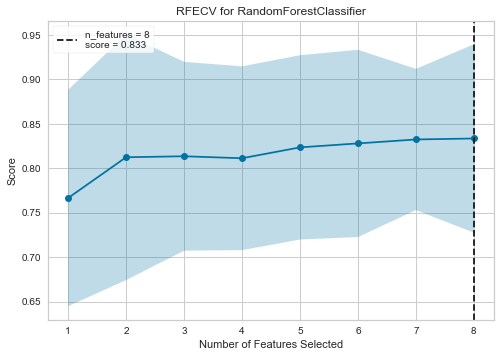

<AxesSubplot:title={'center':'RFECV for RandomForestClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [99]:
rfe = RFECV_visual(model,cv=StratifiedKFold(5), random_state=20,scoring='roc_auc')
rfe.fit(X_train, y_train)
rfe.rfe_estimator_.ranking_
rfe.rfe_estimator_.n_features_
rfe.rfe_estimator_.support_
rfe.poof()

In [100]:
rfe = RFECV(model,cv=StratifiedKFold(5),scoring='f1_weighted')

In [101]:
rfe.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_depth=4, n_estimators=127, n_jobs=-1,
                                       random_state=10, warm_start=True),
      scoring='f1_weighted')

In [102]:
rfe.ranking_

array([1, 1, 4, 2, 5, 3, 6, 7])

In [94]:
rfe.feature_names_in_

array(["('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE, баллы')",
       "('ИСХОДНАЯ ЭХОКГ', 'иММ ЛЖ')",
       "('АНТРОПОФИЗИОМЕТРИЯ', 'Возраст')",
       "('БИОМАРКЕРЫ', 'PCSK9 (нг/мл)')",
       "('ЛАБОРАТОРНЫЕ ПОКАЗАТЕЛИ', 'ЛПВП, ммоль/л')",
       "('ЛАБОРАТОРНЫЕ ПОКАЗАТЕЛИ', 'Хсобщ, ммоль/л')",
       "('АНТРОПОФИЗИОМЕТРИЯ', 'ИМТ')", "('ИСХОДНАЯ ЭХОКГ', 'ПЖ')"],
      dtype=object)

#### Class definition

In [61]:
class Feature_selector:
    '''
    Class for feature selection.
    Traget and dataset should be specified.
    Tuned parameters of model are read, and model is retrained.
    Chosen selectors are used to determine top N features. 
    '''

    def __init__(self,
                 targets: list, #  = ['combined'] cardiovascular death, revascularization, combined
                 datasets: list, #  = ['a'] a, b, c, abc
                 subsets: list, #  = ['Biomarkers + Clinical'] Biomarkers, Clinical, Biomarkers + Clinical
                 models: list, #  = ['randomforest'] svm, knn, LogisticRegression, catboost, randomforest
                 selectors: list, #  = ['SHAP'] RF_feature_importance, SFS/RFE, SHAP
                 N: int = 10,
                 random_state: int = 20):
        self.targets = targets
        self.datasets = datasets
        self.subsets = subsets
        self.models = models
        self.random_state = random_state
        self.selectors = selectors
        self.N = N
        self.save=True
        self.masked_cols = \
                            ["('ИСХОДНАЯ ЭХОКГ', 'КДР ЛЖ ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'КДО ЛЖ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'КСР ЛЖ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'КСО ЛЖ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'ММ ЛЖ')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'CRUSADE Bleeding Score')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'Risk of In-Hospital Major Bleeding,%')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-1, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-2, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-3, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-4, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-1, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-2, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-3, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-4, с')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE 1-год, % ')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE   1-год, % ')",]
        

    def get_train_test(self, link_train, link_test, dataset, subset):
        '''
        Function for getting train and test for specified dataset and subset
        '''
        
        datasets = {
            'a' : np.array([1, 61, 147]),
            'b' : np.array([1, 72, 78]),
            'c' : np.array([1, 101, 106]),
            'abc' : np.array([1, 57])}

        if subset == 'Biomarkers + Clinical':
            idx1, idx2 = datasets[dataset][[0,2]]
        elif subset == 'Biomarkers':
            idx1, idx2 = datasets[dataset][[1,2]]
        else:
            idx1, idx2 = datasets[dataset][[0,1]]
        X_train = pd.read_excel(link_train, header=[0], usecols=list(range(idx1,idx2)))
        y_train = pd.read_excel(link_train, header=[0], usecols=[datasets[dataset][-1]])
        X_test  = pd.read_excel(link_test, header=[0], usecols=list(range(idx1,idx2)))
        y_test  = pd.read_excel(link_test, header=[0], usecols=[datasets[dataset][-1]])
        # remove columns that ASVorobiev told me to remove
        X_train.drop(labels=self.masked_cols, axis=1, errors='ignore', inplace=True)
        X_test.drop(labels=self.masked_cols, axis=1, errors='ignore', inplace=True)

        return X_train, X_test, y_train, y_test


    def get_model_instance(self, model, optimisation_file, X_train, y_train):
        '''
        Get trained model instance
        '''

        try:
            params = optimisation_file[optimisation_file['rank_test_score']==1][["params"]].iloc[0]
            params = ast.literal_eval(params[0])
            if model == 'randomforest':
                model_instance = RandomForestClassifier(**params)
            elif model == 'knn':
                model_instance = KNeighborsClassifier(**params)
            elif model == 'svm':
                model_instance = SVC(**params)
            elif model == 'LogisticRegression':
                model_instance = LogisticRegression(**params)
        except:
            # catboost has additional parameters
            params = optimisation_file['params'][0]
            params = ast.literal_eval(params)
            model_instance = CatBoostClassifier(**c_boost_params, **params)

        model_instance.fit(X_train, y_train)

        return model_instance

      
    def get_shap_values_summary(self, model_instance, X_train, X_test, model, path,):
        '''
        Function calculates shap values.
        Calculation is different for tree-based models and not-tree-based models.
        Bar and violin plots are made.
        '''

        # TODO: fix SHAP values calculation for not-tree-based models

        if model == 'svm' or model == 'LogisticRegression':
            # returns zeros and I dont know why
            explainer = shap.Explainer(model_instance.predict, pd.concat([X_train, X_test]))
            shap_values = explainer(pd.concat([X_train, X_test]))

        if model == 'randomforest' or model == 'catboost':
            explainer = shap.TreeExplainer(model=model_instance, 
                                          model_output='raw', 
                                          feature_perturbation='interventional',)
            shap_values = explainer(pd.concat([X_train, X_test]).values)
        
        # save values
        f = pd.DataFrame(np.stack([X_train.columns, abs(shap_values.values[:,:,0]).mean(axis=0)], axis=1), columns=['features', 'values'])
        if self.save:
            f.to_excel(f'{path}{model}_values.xlsx')
        f = None

        # get Bar and Violin plots
        shap.summary_plot(shap_values=shap_values.values[:,:,0], features=pd.concat([X_train, X_test]), feature_names=X_train.columns, plot_type="bar", plot_size=(19.5,6.75), show=False)
        # plt.title(label='SHAP values', loc='center', pad=None, 
        #           fontdict={'fontsize': 16,
        #                     # 'fontweight' : rcParams['axes.titleweight'],
        #                     'verticalalignment': 'baseline',
        #                     'horizontalalignment': 'center'})
        if self.save:
            plt.savefig(f'{path}{model}_SHAP_barplot.pdf')
        # plt.show()
        plt.clf()
        shap.summary_plot(shap_values=shap_values.values[:,:,0], features=pd.concat([X_train, X_test]), feature_names=X_train.columns, plot_type="layered_violin", color='coolwarm', plot_size=(19.5,6.75), show=False)
        if self.save:
            plt.savefig(f'{path}{model}_SHAP_violinplot.pdf')
        plt.clf()
        # plt.show()
        # return path

        # clear_output()

    
    def get_rfecv_importance(model_instance, X_train, X_test, model, random_state, path, N,):

        # TODO: findout how to get ranking for all features

        # save values
        feature_importances = pd.DataFrame(np.stack([X_train.columns, model_instance.feature_importances_], axis=1), columns=['features', 'values'])
        # sort
        feature_importances = feature_importances.sort_values("values", ascending=False, ignore_index=True)

        rfe = RFECV(model_instance,cv=StratifiedKFold(5), random_state=random_state,scoring='f1_weighted', n_features_to_select=1)
        rfe.fit(X_train[feature_importances['features'][:10]], y_train)

        rfe = RFECV(model_instance,cv=StratifiedKFold(5), random_state=random_state,scoring='f1_weighted')
        rfe.fit(X_train[feature_importances['features'][:25]], y_train)

    
    def get_rf_importance(self, model_instance, X_train, X_test, model, path, N,):
        '''
        Function calculates Random Forest importances.
        Calculation is different for tree-based models and not-tree-based models.
        Bar plot is made.
        '''
        
        # save values
        feature_importances = pd.DataFrame(np.stack([X_train.columns, model_instance.feature_importances_], axis=1), columns=['features', 'values'])
        feature_importances.to_excel(f'{path}values.xlsx')

        # sort and normalize
        feature_importances = feature_importances.sort_values("values", ascending=False, ignore_index=True)
        feature_importances['values'] = feature_importances['values']/feature_importances['values'][0]

        # get Bar plot
        fig = px.bar(
                    x='values',
                    orientation='h',
                    data_frame=feature_importances[:N][::-1],
                    y='features')
        
        # figure settings
        fig.update_layout(autosize=False, width=1000, height=450,) 
        fig.update_xaxes(title='Relative importance')
        fig.update_yaxes(title='')
        fig.update_layout(
                      # xaxis2={"overlaying": "x", "range": [-0.515, 4.515], "showticklabels": False},
                      # bargap=0.30,
                      # bargroupgap=0.3,
                      # legend=dict(orientation="v", title='Datasets'), 
                      title=dict(text='Feature importance from Random Forest model', x=0.5,),
                      margin=dict(l=60, r=20, t=60, b=40),)

        # fig.show(renderer='colab')
        if self.save:
            fig.write_image(f'{path}values.pdf', engine="kaleido")

    def get_importances(self):
      '''
      Function for feature selection.
      Traget and dataset should be specified.
      Tuned parameters of model are read, and model is retrained.
      Chosen selectors are used to determine top N features. 
      '''

      for target in tqdm(self.targets, desc='Targets loop', leave=True):

          for dataset in tqdm(self.datasets, leave=False):
              # links to preprocessed 'train' and 'test' data
              link_train = f'./HSE project/Preprocessed Data/{target}/train_{dataset}.xlsx'
              link_test = f'./HSE project/Preprocessed Data/{target}/test_{dataset}.xlsx'


              for subset in tqdm(self.subsets, leave=False ):
                  # upload 'train' and 'test' data
                  X_train, X_test, y_train, y_test = self.get_train_test(link_train, link_test, dataset, subset)

                  # path to file with tuned parameters
                  path = f"./HSE project/Optimisation data/{target}/{subset} {dataset.upper()}/all/"

                  for model in self.models:
                      # read file with tuned parameters
                      try:
                          optimisation_file = pd.read_excel(f'{path}{model}_optimisation.xlsx', header=[0])
                      except:
                          print(f"There is no file in {path} \n")
                          continue

                      # get trained model instance
                      model_instance = self.get_model_instance(model=model, optimisation_file=optimisation_file, X_train=X_train, y_train=y_train) # ...

                      for selector in self.selectors:
                          # тут нужно вызывать отдельные функции для SHAP, RF_importance, RFE or SFS
                          results_path = f'./HSE project/Feature selection/{target}/{subset} {dataset.upper()}/{selector}/' # values.xslx, graph.pdf
                          if selector == 'SHAP':
                              self.get_shap_values_summary(model_instance=model_instance, X_train=X_train, X_test=X_test, model=model, path=results_path)
                          if selector == 'RF_feature_importance':
                              self.get_rf_importance(model_instance=model_instance, X_train=X_train, X_test=X_test, model=model, path=results_path, N=self.N)
                          if selector == 'SFS':
                              self.get_rfecv_importance(model_instance=model_instance, X_train=X_train, X_test=X_test, random_state=self.random_state, model=model, path=results_path, N=self.N)


#### Selection

In [ ]:
fs = Feature_selector(
    targets = ['combined'], # cardiovascular death, revascularization, combined
    datasets = ['a', 'c', ], # a, b, c, abc
    subsets = ['Biomarkers + Clinical'], # Biomarkers, Clinical, Biomarkers + Clinical
    models = ['randomforest'], # svm, knn, LogisticRegression, catboost, randomforest
    selectors = ['SHAP', 'RF_feature_importance'], # RF_feature_importance, SFS/RFE, SHAP
)
fs.save=True
fs.get_importances()

fs.datasets = ['abc']
fs.subsets = ['Clinical']
fs.get_importances()

Targets loop:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Targets loop:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 1404x486 with 0 Axes>

In [ ]:
fs = Feature_selector(
    targets = ['combined'], # cardiovascular death, revascularization, combined
    datasets = ['a', 'c', ], # a, b, c, abc
    subsets = ['Clinical'], # Biomarkers, Clinical, Biomarkers + Clinical
    models = ['randomforest'], # svm, knn, LogisticRegression, catboost, randomforest
    selectors = ['SHAP', 'RF_feature_importance'], # RF_feature_importance, SFS/RFE, SHAP
)
fs.save=True

In [ ]:
fs.get_importances()

Targets loop:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 1404x486 with 0 Axes>

# Tuning 

#### Class definition

In [ ]:
class Tunning:
    '''
    Class for tuning.
    # Traget and dataset should be specified.
    # Tuned parameters of model are read, and model is retrained.
    # Chosen selectors are used to determine top N features. 
    '''

    def __init__(self,
                 targets: list, #  = ['combined'] cardiovascular death, revascularization, combined
                 datasets: list, #  = ['a'] a, b, c, abc
                 subsets: list, #  = ['Biomarkers + Clinical'] Biomarkers, Clinical, Biomarkers + Clinical
                 models: list, #  = ['randomforest'] svm, knn, LogisticRegression, catboost, randomforest
                 selectors: list, #  = ['SHAP'] RF_feature_importance, SFS/RFE, SHAP
                 catboost_score: str = 'F:beta=1',
                 score = 'f1', # score = my_f2_scorer(), 'f1', 'accuracy', 'precision', 'recall', 'roc_auc'
                 N: int = 10,            # catboost_score = 'F1' 'F:beta=2'
                 random_state: int = 20):
        self.targets = targets
        self.datasets = datasets
        self.subsets = subsets
        self.models = models
        self.random_state = random_state
        self.selectors = selectors
        self.N = N
        self.save = True
        self.score = score
        self.catboost_score = catboost_score
        self.cross_validation = StratifiedKFold(5)

        self.logistic_regression = True
        self.knn = True
        self.random_forest = True
        self.svm = True
        self.catboost = True
        self.masked_cols = \
                            ["('ИСХОДНАЯ ЭХОКГ', 'КДР ЛЖ ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'КДО ЛЖ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'КСР ЛЖ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'КСО ЛЖ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'ММ ЛЖ')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'CRUSADE Bleeding Score')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'Risk of In-Hospital Major Bleeding,%')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-1, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-2, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-3, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-4, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-1, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-2, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-3, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-4, с')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE 1-год, % ')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE   1-год, % ')",]

    def get_train_test(self, link_train, link_test, dataset, subset):
        '''
        Function for getting train and test for specified dataset and subset
        '''
        
        datasets = {
            'a' : np.array([1, 61, 147]),
            'b' : np.array([1, 72, 78]),
            'c' : np.array([1, 101, 106]),
            'abc' : np.array([1, 57])}

        if subset == 'Biomarkers + Clinical':
            idx1, idx2 = datasets[dataset][[0,2]]
        elif subset == 'Biomarkers':
            idx1, idx2 = datasets[dataset][[1,2]]
        else:
            idx1, idx2 = datasets[dataset][[0,1]]
        X_train = pd.read_excel(link_train, header=[0], usecols=list(range(idx1,idx2)))
        y_train = pd.read_excel(link_train, header=[0], usecols=[datasets[dataset][-1]])
        X_test  = pd.read_excel(link_test, header=[0], usecols=list(range(idx1,idx2)))
        y_test  = pd.read_excel(link_test, header=[0], usecols=[datasets[dataset][-1]])
        # remove columns that ASVorobiev told me to remove
        X_train.drop(labels=self.masked_cols, axis=1, errors='ignore', inplace=True)
        X_test.drop(labels=self.masked_cols, axis=1, errors='ignore', inplace=True)

        return X_train, X_test, y_train, y_test


    def tuning(self, path, X_train, X_test, y_train, y_test):
        if self.logistic_regression:
            self.logistic_regression_tuning(self.score, self.cross_validation, path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,)
        if self.knn:
            self.knn_tuning(self.score, self.cross_validation, path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,)     
        if self.random_forest:
            self.random_forest_tuning(self.score, self.cross_validation, path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,)     
        if self.svm:
            self.svm_tuning(self.score, self.cross_validation, path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,)     
        if self.catboost:
            self.catboost_tuning(self.catboost_score, self.cross_validation, path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,)  

    def logistic_regression_tuning(self, score, cross_validation, path, X_train, X_test, y_train, y_test):
      
        model = LogisticRegression(random_state=10)
        # calibrate hyper-parameters: perform gridsearch with cross-validation
        clf = GridSearchCV(
                          estimator = model, 
                          param_grid = parameters_LR_model,
                          scoring = score,    
                          #  refit = my_f2_scorer,
                          cv = cross_validation,
                          n_jobs = -1
                          )              
        clf.fit(X_train, y_train)
        model = clf.best_estimator_

        # write down optimisation parameters
        optimisation_table = pd.DataFrame(clf.cv_results_)
        # add roc_auc fCV values
        optimisation_table['roc_auc'] = str(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        optimisation_table['roc_auc_mean'] = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        optimisation_table['roc_auc_std'] = np.std(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        # save optimisation parameters and CV values of F-metric and ROC_AUC
        optimisation_table.to_excel(f'{path}LogisticRegression_optimisation.xlsx') 
        clear_output()


    def knn_tuning(self, score, cross_validation, path, X_train, X_test, y_train, y_test):
        
        model = KNeighborsClassifier()
        # calibrate hyper-parameters: perform gridsearch with cross-validation = 5 
        clf = GridSearchCV(
                          estimator=model, 
                          param_grid=parameters_knn,
                          scoring=score,
                          #  refit=my_f2_scorer,
                          cv=cross_validation,
                          n_jobs=-1
                          )              
        clf.fit(X_train, y_train)
        model = clf.best_estimator_

        # write down optimisation parameters
        optimisation_table = pd.DataFrame(clf.cv_results_)
        # add roc_auc fCV values
        optimisation_table['roc_auc'] = str(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        optimisation_table['roc_auc_mean'] = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        optimisation_table['roc_auc_std'] = np.std(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        # save optimisation parameters and CV values of F-metric and ROC_AUC 
        optimisation_table.to_excel(f'{path}knn_optimisation.xlsx')
        clear_output()


    def random_forest_tuning(self, score, cross_validation, path, X_train, X_test, y_train, y_test):
      
        model = RandomForestClassifier(random_state=10)

        # calibrate hyper-parameters: perform gridsearch with cross-validation = 5 
        clf = GridSearchCV(
                          estimator=model, 
                          param_grid=parameters_random_forest_model,
                          scoring=score,  
                          #  refit=my_f2_scorer,
                          cv=cross_validation,
                          n_jobs=-1
                          )              
        clf.fit(X_train, y_train)
        model = clf.best_estimator_

        # write down optimisation parameters
        optimisation_table = pd.DataFrame(clf.cv_results_)
        # add roc_auc fCV values
        optimisation_table['roc_auc'] = str(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        optimisation_table['roc_auc_mean'] = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        optimisation_table['roc_auc_std'] = np.std(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        # save optimisation parameters and CV values of F-metric and ROC_AUC
        optimisation_table.to_excel(f'{path}randomforest_optimisation.xlsx')
        clear_output()

    def svm_tuning(self, score, cross_validation, path, X_train, X_test, y_train, y_test):
  
        model = SVC()

        # calibrate hyper-parameters: perform gridsearch with cross-validation = 5 
        clf = GridSearchCV(
                          estimator=model, 
                          param_grid=parameters_svm,
                          scoring=score,  
                          # refit=score[0],
                          cv=cross_validation,
                          n_jobs=-1
                          )              
        clf.fit(X_train, y_train)
        model = clf.best_estimator_

        # write down optimisation parameters
        optimisation_table = pd.DataFrame(clf.cv_results_)

        # add roc_auc fCV values
        optimisation_table['roc_auc'] = str(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        optimisation_table['roc_auc_mean'] = np.mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        optimisation_table['roc_auc_std'] = np.std(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        # save optimisation parameters and CV values of F-metric and ROC_AUC
        optimisation_table.to_excel(f'{path}svm_optimisation.xlsx')
        clear_output()
        

    def catboost_tuning(self, catboost_score, cross_validation, path, X_train, X_test, y_train, y_test):

        np.random.seed(10)
        catboost = CatBoostClassifier(
                                    eval_metric=catboost_score,
                                    verbose=False,
                                    early_stopping_rounds=100,
                                    #cat_features=cat_features,
                                    task_type="CPU",
                                    iterations = 500,
                                    random_seed=10)


        grid_res = catboost.grid_search(catboost_parameters,
                                        X_train,
                                        y_train,
                                        cv=cross_validation,
                                        search_by_train_test_split=True,
                                        calc_cv_statistics=True,
                                        refit=True,
                                        shuffle=True,
                                        partition_random_seed=10,
                                        verbose=True,
                                        stratified=True)

        # write down optimisation parameters
        cv_results = pd.DataFrame(grid_res['cv_results'])
        cv_results['params'] = 0
        cv_results['params'][0:3] = str(grid_res['params'])
        # add roc_auc fCV values
        cv_results['roc_auc'] = str(cross_val_score(catboost, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        cv_results['roc_auc_mean'] = np.mean(cross_val_score(catboost, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        cv_results['roc_auc_std'] = np.std(cross_val_score(catboost, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc'))
        # save optimisation parameters and CV values of F-metric and ROC_AUC
        cv_results.to_excel(f'{path}catboost_optimisation.xlsx')
        clear_output()


    def metric_table(self, path, X_train, y_train, X_test, y_test):  #, X_train=X_train, y_train=y_train
        '''
        This function provides scores for gridsearch F1-score and metrics for test dataset
        '''
        # read gridsearch tables
        randomforest_optimisation = pd.read_excel(f'{path}randomforest_optimisation.xlsx', header=[0]) #/content/  ./imp_feat
        svm_optimisation = pd.read_excel(f'{path}svm_optimisation.xlsx', header=[0])
        knn_optimisation = pd.read_excel(f'{path}knn_optimisation.xlsx', header=[0])
        LogisticRegression_optimisation = pd.read_excel(f'{path}LogisticRegression_optimisation.xlsx', header=[0])
        catboost_optimisation = pd.read_excel(f'{path}catboost_optimisation.xlsx', header=[0])

        params = randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["params"]].iloc[0]
        params = ast.literal_eval(params[0])
        random_forest_model = RandomForestClassifier(**params)
        # 
        params = svm_optimisation[svm_optimisation['rank_test_score']==1][["params"]].iloc[0]
        params = ast.literal_eval(params[0])
        SVM_model = SVC(**params)
        # 
        # params = nn_optimisation[nn_optimisation['rank_test_score']==1][["params"]].iloc[0]
        # params = ast.literal_eval(params[0])
        # newral_network_model = MLPClassifier(**params)
        # 
        params = knn_optimisation[knn_optimisation['rank_test_score']==1][["params"]].iloc[0]
        params = ast.literal_eval(params[0])
        knn_model = KNeighborsClassifier(**params)
        # 
        params = LogisticRegression_optimisation[LogisticRegression_optimisation['rank_test_score']==1][["params"]].iloc[0]
        params = ast.literal_eval(params[0])
        LR_model = LogisticRegression(**params)
        # 
        params = catboost_optimisation['params'][0]
        params = ast.literal_eval(params)
        catboost_model = CatBoostClassifier(**c_boost_params, **params)

        models = [
        random_forest_model,
        SVM_model,
        # newral_network_model,
        LR_model,
        knn_model,
        catboost_model
        ]

        mcc_score, f1_score,f2_score, accuracy_score, TP_rate_score, recall_score, auc_precision_recall, roc_auc_score= [], [], [], [], [], [], [], []
        tn, fp, fn, tp = [], [], [], []

        for model in models:
            model.fit(X_train, y_train)
            forecast = model.predict(X_test)
            forecast_proba = model.predict_proba(X_test)

            # mcc_score.append(mcc(y_test, forecast))                                   # MCC
            f1_score.append(f1(y_test, forecast))                                       # F1
            f2_score.append(f2_func(y_test, forecast))                                  # F1
            accuracy_score.append(accuracy(y_test, forecast))                           # Accuracy  
            TP_rate_score.append(TP_rate(y_test, forecast))                             # TP rate   tp / (tp + fp)
            recall_score.append(recall(y_test, forecast))                               # TN rate
            auc_precision_recall.append(average_precision_score(y_test, forecast_proba[:,1]))      # PR AUC
            roc_auc_score.append(roc_auc(y_test, forecast_proba[:,1]))                       # ROC AUC
            tn.append(confusion_matrix(y_test, forecast).ravel()[0])                  # number of true negative
            fp.append(confusion_matrix(y_test, forecast).ravel()[1])                  # number of false positive
            fn.append(confusion_matrix(y_test, forecast).ravel()[2])                  # number of false negative
            tp.append(confusion_matrix(y_test, forecast).ravel()[3])                  # number of true positive

        # create matrix table 
        metrics_table = pd.DataFrame(columns=pd.MultiIndex.from_product([["F2, train set, cv=5"],["mean", 'std']]))
        # metrics_table[("Scores on the test set","MCC")] = mcc_score
        metrics_table[("Scores on the test set","F1")] = f1_score
        metrics_table[("Scores on the test set","F2")] = f2_score
        metrics_table[("Scores on the test set","Accuracy")] = accuracy_score
        metrics_table[("Scores on the test set","Precision")] = TP_rate_score
        metrics_table[("Scores on the test set","Recall")] = recall_score
        metrics_table[("Scores on the test set","PR_AUC")] = auc_precision_recall
        metrics_table[("Scores on the test set","ROC_AUC")] = roc_auc_score
        metrics_table[("Confusion matrix","TN")] = tn
        metrics_table[("Confusion matrix","FP")] = fp
        metrics_table[("Confusion matrix","FN")] = fn
        metrics_table[("Confusion matrix","TP")] = tp

        # modify the rows names
        metrics_table.index = [
                    "Random Forest",
                    "SVM",
                    # "Multi-layer Perceptron",
                    "Logistic Regression",
                    "KNN",
                    "CatBoost"
                    ]



        # add cross validated F2 scores on the train set
        mean = []
        std = []
        mean_test_f1,std_test_f1 = randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
        randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
        mean.append(mean_test_f1); std.append(std_test_f1)
        mean_test_f1,std_test_f1 = svm_optimisation[svm_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
        mean.append(mean_test_f1); std.append(std_test_f1)
        # mean_test_f1,std_test_f1 = nn_optimisation[nn_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
        # mean.append(mean_test_f1); std.append(std_test_f1)
        mean_test_f1,std_test_f1 = LogisticRegression_optimisation[LogisticRegression_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
        mean.append(mean_test_f1); std.append(std_test_f1)
        mean_test_f1,std_test_f1 = knn_optimisation[knn_optimisation['rank_test_score']==1][["mean_test_score","std_test_score"]].iloc[0]
        mean.append(mean_test_f1); std.append(std_test_f1)
        mean_test_f1,std_test_f1 = catboost_optimisation[['test-F:beta=1-mean', 'test-F:beta=1-std']].iloc[catboost_optimisation.shape[0]-1]
        mean.append(mean_test_f1); std.append(std_test_f1)
        

        metrics_table[("F2, train set, cv=5","mean")] = mean
        metrics_table[("F2, train set, cv=5","std")] = std

        # add cross validated F2 scores on the train set
        mean_roc_auc = []
        std_roc_auc = []
        mean_test_roc_auc,std_test_roc_auc = randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
        randomforest_optimisation[randomforest_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
        mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
        mean_test_roc_auc,std_test_roc_auc = svm_optimisation[svm_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
        mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
        # mean_test_roc_auc,std_test_roc_auc = nn_optimisation[nn_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
        # mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
        mean_test_roc_auc,std_test_roc_auc = LogisticRegression_optimisation[LogisticRegression_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
        mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
        mean_test_roc_auc,std_test_roc_auc = knn_optimisation[knn_optimisation['rank_test_score']==1][["roc_auc_mean","roc_auc_std"]].iloc[0]
        mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)
        mean_test_roc_auc,std_test_roc_auc = catboost_optimisation[["roc_auc_mean","roc_auc_std"]].iloc[catboost_optimisation.shape[0]-1]
        mean_roc_auc.append(mean_test_roc_auc); std_roc_auc.append(std_test_roc_auc)

        metrics_table[("ROC_AUC, train set, cv=5","mean")] = mean_roc_auc
        metrics_table[("ROC_AUC, train set, cv=5","std")] = std_roc_auc

        return metrics_table

    def tune(self):
          '''
          Function for feature selection.
          Traget and dataset should be specified.
          Tuned parameters of model are read, and model is retrained.
          Chosen selectors are used to determine top N features. 
          '''

          for target in tqdm(self.targets, desc='Targets loop', leave=True):

              for dataset in tqdm(self.datasets, leave=False, desc='datasets'):
                  # links to preprocessed 'train' and 'test' data
                  link_train = f'./HSE project/Preprocessed Data/{target}/train_{dataset}.xlsx'
                  link_test = f'./HSE project/Preprocessed Data/{target}/test_{dataset}.xlsx'


                  for subset in tqdm(self.subsets, leave=False, desc='subsets'):

                      # # path to file with tuned parameters
                      # path = f"./HSE project/Optimisation data/{target}/{subset} {dataset.upper()}/all/"


                      for selector in tqdm(self.selectors, leave=False, desc='subsets'):
                          # SHAP, 
                          try:
                              top = list(pd.read_excel(f'./HSE project/Feature selection/{target}/{subset} {dataset.upper()}/{selector}/randomforest_values.xlsx', header=[0], index_col=[0]).sort_values(by='values', ascending=False)['features'][:self.N].values)
                          except:
                              top = list(pd.read_excel(f'./HSE project/Feature selection/{target}/{subset} {dataset.upper()}/{selector}/values.xlsx', header=[0], index_col=[0]).sort_values(by='values', ascending=False)['features'][:self.N].values)
                          
                          # upload 'train' and 'test' data
                          X_train, X_test, y_train, y_test = self.get_train_test(link_train, link_test, dataset, subset)
                          X_train = X_train[top]
                          X_test = X_test[top]
                          optimisation_path = f"./HSE project/Optimisation data/{target}/{subset} {dataset.upper()}/top/{selector}/"

                          self.tuning(path = optimisation_path, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
                          metrics_table = self.metric_table(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, path=optimisation_path, )
                          metrics_table.to_excel(f'{optimisation_path}metrics_table.xlsx')


#### Tunning

In [ ]:
tuner = Tunning(
        targets = ['combined'], # cardiovascular death, revascularization, combined
    datasets = ['a', 'c' ], # a, b, c, abc
    subsets = ['Biomarkers + Clinical'], # Biomarkers, Clinical, Biomarkers + Clinical
    models = ['randomforest'], # svm, knn, LogisticRegression, catboost, randomforest
    selectors = ['SHAP', 'RF_feature_importance'], # RF_feature_importance, SFS/RFE, SHAP
)

# tuner.logistic_regression = False
# tuner.knn = False
# tuner.random_forest = False
# tuner.svm = False
# tuner.catboost = False



In [ ]:
tuner.tune()

In [ ]:
# tuner.selectors = ['RF_feature_importance'] # RF_feature_importance, SFS/RFE, SHAP
# tuner.tune()

tuner.datasets = ['abc'] # a, b, c, abc
tuner.subsets = ['Clinical'] # Biomarkers, Clinical, Biomarkers + Clinical
tuner.selectors = ['SHAP', 'RF_feature_importance'] # RF_feature_importance, SFS/RFE, SHAP
tuner.tune()


In [ ]:
tuner.datasets = ['a', 'c'] # a, b, c, abc
tuner.subsets = ['Clinical'] # Biomarkers, Clinical, Biomarkers + Clinical
tuner.selectors = ['SHAP', 'RF_feature_importance'] # RF_feature_importance, SFS/RFE, SHAP
tuner.tune()

# Results

In [17]:
results_path = './HSE project/Graphics/combined/Feature selection/'

### Scores of models

In [ ]:
# what metric to evaluate
# F2 F1 ROC_AUC
metrics = ['F2', 'ROC_AUC']

for metric in metrics:
    # list of paths
    paths = [
            './HSE project/Optimisation data/combined/Biomarkers A/all biomarkers/',
            './HSE project/Optimisation data/combined/Biomarkers B/all biomarkers/',
            './HSE project/Optimisation data/combined/Biomarkers C/all biomarkers/',
            './HSE project/Optimisation data/combined/Clinical ABC/all clinical/',
            './HSE project/Optimisation data/combined/Biomarkers A + Clinical/all biomarkers and clinical/',
            './HSE project/Optimisation data/combined/Biomarkers B + Clinical/all biomarkers and clinical/',
            './HSE project/Optimisation data/combined/Biomarkers C + Clinical/all biomarkers and clinical/',
            './HSE project/Optimisation data/combined/Clinical A/all biomarkers and clinical/',
            './HSE project/Optimisation data/combined/Clinical B/all biomarkers and clinical/',
            './HSE project/Optimisation data/combined/Clinical C/all biomarkers and clinical/',
            ]

    # create datframe for scores
    datasets = pd.DataFrame(columns=['biomarkers A','biomarkers B','biomarkers C','Clinical+biomarkers ABC','Clinical+biomarkers A','Clinical+biomarkers B','Clinical+biomarkers C', 'Clinical A','Clinical B','Clinical C'])
    datasets_mean = pd.DataFrame(columns=['biomarkers A','biomarkers B','biomarkers C','Clinical+biomarkers ABC','Clinical+biomarkers A','Clinical+biomarkers B','Clinical+biomarkers C', 'Clinical A','Clinical B','Clinical C'])
    datasets_std = pd.DataFrame(columns=['biomarkers A','biomarkers B','biomarkers C','Clinical+biomarkers ABC','Clinical+biomarkers A','Clinical+biomarkers B','Clinical+biomarkers C', 'Clinical A','Clinical B','Clinical C'])

    # get dataframe with with scores of models from different datasets
    for i in range(len(paths)):
        table = pd.read_excel(f'{paths[i]}metrics_table.xlsx', header=[0,1], index_col=[0]) #ensemble: advanced_models_metrics, standart: metrics_table
        datasets[datasets.columns[i]] = list(table.loc[:, ('Scores on the test set', metric)].values.round(3)) 
        if metric == 'F2':
            datasets_mean[datasets_mean.columns[i]] = list(table.loc[:, ('F2, train set, cv=5', 'mean')].values.round(3)) 
            datasets_std[datasets_std.columns[i]] = list(table.loc[:, ('F2, train set, cv=5', 'std')].values.round(3)) 
        if metric == 'ROC_AUC':
            datasets_mean[datasets_mean.columns[i]] = list(table.loc[:, ('ROC_AUC, train set, cv=5', 'mean')].values.round(3)) 
            datasets_std[datasets_std.columns[i]] = list(table.loc[:, ('ROC_AUC, train set, cv=5', 'std')].values.round(3)) 

    # list of models
    # standart models
    models=['RandomForest', 'SVM', 'Logistic Regression', 'KNN', 'CatBoost']
    # ensemble models
    # models=['Hard voting', 'Soft voting', 'Stacking', 'Bagging', 'adaBoosting']

    # create the graph
    fig = go.Figure(data=[go.Bar(name=column, x=models, y=datasets[column]) for column in datasets.columns])
        
    # add error whiskers from gridsearchCV
    if True:
        fig.add_traces([go.Box(name=column, x=models, 
                              y=datasets_mean[column], 
                              #  xaxis="x1",  
                              
                              marker=dict(color="black"), 
                              showlegend = False) for column in datasets.columns])
        fig.update_traces(
        selector=dict(type="box"), # update only boxes
        boxpoints="all", # show points
        pointpos=0, # centered
        jitter=0, # no jitter
        line_color="rgba(255,255,255,0)", # hide box lines
        fillcolor="rgba(255,255,255,0)", # hide box fill
        
        )
        fig.update_layout(boxmode="group",)

        fig.add_traces([go.Bar(name=column, x=models, 
                              y=datasets_mean[column], 
                              xaxis="x2",  
                              error_y=dict(type='data',  
                                            array=datasets_std[column], 
                                            color="rgba(0,0,0,1)",
                                            thickness=1), 
                              marker=dict(opacity=0,
                                          #  color="rgba(255,255,255,0)"
                                          ), 
                              showlegend = False) for column in datasets.columns])  
        

    fig.update_xaxes(title='Models')
    # Change the bar mode
    fig.update_layout(barmode='group', 
                      xaxis2={"overlaying": "x", "range": [-0.515, 4.515], "showticklabels": False},
                      bargap=0.30,
                      bargroupgap=0.3,
                      legend=dict(orientation="v", title='Datasets'), 
                      title=dict(text=f'{metric} score', x=0.5,),
                      margin=dict(l=60, r=20, t=60, b=40),)

    fig.update_yaxes(title='Score', range=[0., 1.0])


    # add dotted line for ROC AUC = 0.5
    if metric == 'ROC_AUC':
        fig.add_shape(type='line',
                        x0=-0.5,
                        y0=0.5,
                        x1=4.5,
                        y1=0.5,
                        line=dict(color='firebrick',  width=2, dash='dot'),
                        xref='x',
                        yref='y')   
    # figure size
    fig.update_layout(
        autosize=False,
        width=1300,
        height=450,) 
    fig.show(renderer='colab')
    fig.write_image(f"{results_path}{metric}.pdf", engine="kaleido")

### Compare with Top 10

In [ ]:
# list(pd.read_excel(f'./HSE project/Optimisation data/combined/Clinical C/all/metrics_table.xlsx', header=[0,1], index_col=[0]).loc[:, ('Scores on the test set', 'ROC_AUC')].values.round(3))

#### Class definition

In [7]:
class Subplot:
    '''
    '''

    def __init__(self,
                #  subsets: list, #  = ['Biomarkers + Clinical'] Biomarkers, Clinical, Biomarkers + Clinical
                 selectors: list = ['all features', '10 features (SHAP)', '10 features (RFFI)'], # ['SHAP'] RF_feature_importance, SFS/RFE, SHAP
                 target: str = 'combined', # 'combined' cardiovascular death, revascularization
                 models: list = ['Random Forest', 'SVM', 'Logistic Regression', 'kNN', 'CatBoost'],
                 datasets: list = ['Clinical ABC', 'Clinical+Biomarkers A', 'Clinical+Biomarkers C'], 
                 metric : str = 'ROC_AUC', 
                 N: int = 10,
                 random_state: int = 20):
      
        self.selectors = selectors
        self.width = 1300
        self.length = 1450
        self.metric = metric
        self.datasets = datasets
        self.models = models
        self.colors = px.colors.qualitative.Plotly #['#636EFA', '#EF553B', '#00CC96']
        # list of paths with model metrics for all features
        self.paths = \
        [
        './HSE project/Optimisation data/combined/Clinical ABC/all/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical A/all/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical C/all/',
        ]
        # list of paths with model metrics for 10 features from SHAP selection
        self.paths_shap = \
        [
        './HSE project/Optimisation data/combined/Clinical ABC/top/SHAP/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical A/top/SHAP/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical C/top/SHAP/'
        ]
        # list of paths with model metrics for 10 features from RF_feature_importance selection
        self.paths_rf = \
        [
        './HSE project/Optimisation data/combined/Clinical ABC/top/RF_feature_importance/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical A/top/RF_feature_importance/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical C/top/RF_feature_importance/'
        ]
        self.paths_clinical = []
        self.paths_clinical_shap = []
        self.paths_clinical_rf = []

    def get_data(self, ):
        # create datframe for scores # 'biomarkers A','biomarkers B','biomarkers C',
        # datasets_mean = pd.DataFrame(columns=['Clinical ABC','Clinical+biomarkers A', 'Clinical+biomarkers C'])
        # datasets_std = pd.DataFrame(columns=['Clinical ABC','Clinical+biomarkers A', 'Clinical+biomarkers C'])

        datasets = pd.DataFrame(columns=self.datasets)
        # get dataframe with with scores of models from different datasets
        for i in range(len(self.paths)):
            table = pd.read_excel(f'{self.paths[i]}metrics_table.xlsx', header=[0,1], index_col=[0]) 
            table_shap = pd.read_excel(f'{self.paths_shap[i]}metrics_table.xlsx', header=[0,1], index_col=[0])
            table_rf = pd.read_excel(f'{self.paths_rf[i]}metrics_table.xlsx', header=[0,1], index_col=[0])
            
            try:
                table_clinical = list(pd.read_excel(f'{self.paths_clinical[i-1]}metrics_table.xlsx', header=[0,1], index_col=[0]).loc[:, ('Scores on the test set', self.metric)].values.round(3))
                if i == 0:
                    table_clinical = [0,0,0,0,0]; table_clinical_shap = [0,0,0,0,0]; table_clinical_rf = [0,0,0,0,0]
                else:
                    table_clinical = list(pd.read_excel(f'{self.paths_clinical[i-1]}metrics_table.xlsx', header=[0,1], index_col=[0]).loc[:, ('Scores on the test set', self.metric)].values.round(3))
                    table_clinical_shap = list(pd.read_excel(f'{self.paths_clinical_shap[i-1]}metrics_table.xlsx', header=[0,1], index_col=[0]).loc[:, ('Scores on the test set', self.metric)].values.round(3))
                    table_clinical_rf = list(pd.read_excel(f'{self.paths_clinical_rf[i-1]}metrics_table.xlsx', header=[0,1], index_col=[0]).loc[:, ('Scores on the test set', self.metric)].values.round(3))
            except:
                table_clinical = []; table_clinical_shap = []; table_clinical_rf = []
            datasets[datasets.columns[i]] = list(table.loc[:, ('Scores on the test set', self.metric)].values.round(3)) + \
                                            list(table_shap.loc[:, ('Scores on the test set', self.metric)].values.round(3)) + \
                                            list(table_rf.loc[:, ('Scores on the test set', self.metric)].values.round(3)) + \
                                            table_clinical + table_clinical_shap + table_clinical_rf
        return datasets

    def create_subplot(self, legend, data, j):
        subplot = go.Figure(data=[go.Bar(name=self.selectors[i], marker_color=self.colors[i],
                                     x=self.datasets, 
                                     y=data.iloc[5*i+j,:], showlegend=legend, ) for i in list(range(len(self.selectors))) ])
        
        # I wanted to add whiskers, but it did not work correctly
        # subplot.add_traces([go.Bar(name=self.selectors[i], 
        #                            x=self.datasets, 
        #                            y=datasets_mean.iloc[5*i,:], 
        #                            xaxis="x6",  
        #                            error_y=dict(type='data',  
        #                                         array=datasets_std.iloc[5*i,:], 
        #                                         color="rgba(0,0,0,1)",
        #                                         thickness=2), 
        #                 marker=dict(opacity=0,
        #                           #  color="rgba(255,255,255,0)"
        #                             ), 
        #                 showlegend = False) for i in list(range(len([1,2,3])))])  


        return subplot

    def create_figure(self,  ):
        # 
        figure = make_subplots(rows=5, cols=1, horizontal_spacing=0.1, vertical_spacing=0.03)
        dataframe = self.get_data()

        for i, model in enumerate(self.models):
              legend=True if i==1 else False
              subplot = self.create_subplot(legend=legend, data=dataframe, j=i)
              for data in subplot.data:
                    figure.append_trace(data, row=i+1, col=1)
                    if self.metric=='ROC_AUC':
                        figure.add_hline(y=0.5, line=dict(color='black',  width=2, dash='dot'), layer='below', row=i+1, col=1)
              # I want to add whiskers, but it does not work
              # for data in subplot.data[3:]:
              #       figure.append_trace(data, row=i+1, col=1)
              figure.update_yaxes(title=self.models[i], range=[0., 1.], row=i+1, col=1, dtick=0.1,)

        # size update
        figure.update_layout(autosize=False, width=self.width, height=self.length, margin=dict(l=60, r=20, t=80, b=40),) 
        # update legend
        figure.update_layout(showlegend=True,
                             legend=dict(orientation="h", 
                                         title='Datasets:',
                                         yanchor="bottom",
                                         y=1.001,
                                         xanchor="left",
                                         x=0.00, bordercolor="Grey",
                                         borderwidth=0.5),)
        # figure.update_layout()
        figure.update_layout(
                  barmode='group',
                  # xaxis2={"overlaying": "x", "range": [-0.525, 9.525], "showticklabels": False},
                  bargap=0.30,
                  bargroupgap=0.3,
                  title=dict(text=f'{self.metric} score'.replace('_', ' '), x=0.5,),
                  )
        figure.update_layout(
                  barmode='group', 
                  xaxis9={"overlaying": "x", "range": [1.5, 2.5], "showticklabels": False},)

        return figure

#### Creation of graphs

In [ ]:
figtr = Subplot()
z = figtr.create_figure()
z.write_image(f"{results_path}{figtr.metric}-score comparison between all_shap_rf features.pdf", engine="kaleido")

figtr.metric = 'F1'
z = figtr.create_figure()
z.write_image(f"{results_path}{figtr.metric}-score comparison between all_shap_rf features.pdf", engine="kaleido")
z.show(renderer='colab')

In [11]:
figtr = Subplot(
    # datasets=['Clinical ABC', 'Clinical+Biomarkers A', 'Clinical+Biomarkers C'],
    selectors = ['all features', '10 features (SHAP)', '10 features (RFFI)', 'Clinical', 'Clinical shap', 'Clinical rf']

)

figtr.paths_clinical = ['./HSE project/Optimisation data/combined/Clinical A/all/',
                        './HSE project/Optimisation data/combined/Clinical C/all/']

figtr.paths_clinical_shap = ['./HSE project/Optimisation data/combined/Clinical A/top/SHAP/',
                             './HSE project/Optimisation data/combined/Clinical C/top/SHAP/',
                             ]
figtr.paths_clinical_rf = ['./HSE project/Optimisation data/combined/Clinical A/top/RF_feature_importance/',
                             './HSE project/Optimisation data/combined/Clinical C/top/RF_feature_importance/',
                             ]

z = figtr.create_figure()
# z.write_image(f"{results_path}{figtr.metric}-score comparison between all_shap_rf_cli_clishap_clirf features.pdf", engine="kaleido")

# figtr.metric = 'F1'
# z = figtr.create_figure()
# z.write_image(f"{results_path}{figtr.metric}-score comparison between all_shap_rf_cli_clishap_clirf features.pdf", engine="kaleido")
z.show(renderer='colab')

In [ ]:
# for debugging

full_fig = make_subplots(rows=5, cols=1)

for t in fig.data:
    full_fig.append_trace(t, row=1, col=1)
full_fig.update_yaxes(title='Random Forest', range=[0., 1.], row=1, col=1, dtick=0.1,)
# full_fig.update_layout(
for t in fig.data:
    full_fig.append_trace(t, row=2, col=1)
full_fig.update_yaxes(range=[0., 1.], row=2, col=1)
# for t in fig.data:
#     full_fig.append_trace(t, row=3, col=1)
# for t in fig.data:
#     full_fig.append_trace(t, row=4, col=1)
# for t in fig.data:
#     full_fig.append_trace(t, row=5, col=1)

# for t in full_fig.data[::4]:
#     t.update_yaxes(title='Score', range=[0., 1.0])
# full_fig.update_layout(yaxis = dict(range=[0., 1.]))
full_fig.update_layout(
    autosize=False,
    width=1300,
    height=1750,) 

full_fig.update_layout(
                  barmode='group', 
                  showlegend=True,
                  # xaxis2={"overlaying": "x", "range": [-0.525, 9.525], "showticklabels": False},
                  bargap=0.30,
                  bargroupgap=0.3,
                  legend=dict(orientation="h", 
                              title='Datasets:',
                              yanchor="bottom",
                              y=1.001,
                              xanchor="left",
                              x=0.003, bordercolor="Grey",
                              borderwidth=0.5),
                  title=dict(text=f'{metric} score'.replace('_', ' '), x=0.5,),
                  margin=dict(l=60, r=20, t=60, b=40),)
# full_fig.show(renderer='colab')
# full_fig.write_image(f"fvrcd.pdf", engine="kaleido")

In [ ]:
# what metric to evaluate
# ROC_AUC F1 F2
metric = 'F1'

# list of paths
paths = [
        './HSE project/Optimisation data/combined/Clinical ABC/all/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical A/all/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical C/all/'
        ]
# list of paths of shap
paths_shap = [
        './HSE project/Optimisation data/combined/Clinical ABC/top/SHAP/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical A/top/SHAP/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical C/top/SHAP/'
        ]
# list of paths of shap
paths_rf = [
        './HSE project/Optimisation data/combined/Clinical ABC/top/RF_feature_importance/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical A/top/RF_feature_importance/',
        './HSE project/Optimisation data/combined/Biomarkers + Clinical C/top/RF_feature_importance/'
        ]

# create datframe for scores # 'biomarkers A','biomarkers B','biomarkers C',
datasets = pd.DataFrame(columns=['Clinical ABC','Clinical+biomarkers A', 'Clinical+biomarkers C'])
datasets_mean = pd.DataFrame(columns=['Clinical ABC','Clinical+biomarkers A', 'Clinical+biomarkers C'])
datasets_std = pd.DataFrame(columns=['Clinical ABC','Clinical+biomarkers A', 'Clinical+biomarkers C'])

# get dataframe with with scores of models from different datasets
for i in range(len(paths)):
    table = pd.read_excel(f'{paths[i]}metrics_table.xlsx', header=[0,1], index_col=[0]) 
    table_shap = pd.read_excel(f'{paths_shap[i]}metrics_table.xlsx', header=[0,1], index_col=[0])
    table_rf = pd.read_excel(f'{paths_rf[i]}metrics_table.xlsx', header=[0,1], index_col=[0])
    datasets[datasets.columns[i]] = list(table.loc[:, ('Scores on the test set', metric)].values.round(3)) + \
                                    list(table_shap.loc[:, ('Scores on the test set', metric)].values.round(3)) + \
                                    list(table_rf.loc[:, ('Scores on the test set', metric)].values.round(3))

    if metric == 'F1':
        datasets_mean[datasets_mean.columns[i]] = list(table.loc[:, ('F2, train set, cv=5', 'mean')].values.round(3)) + list(table_shap.loc[:, ('F2, train set, cv=5', 'mean')].values.round(3)) + list(table_rf.loc[:, ('F2, train set, cv=5', 'mean')].values.round(3))
        datasets_std[datasets_std.columns[i]] = list(table.loc[:, ('F2, train set, cv=5', 'std')].values.round(3)) + list(table_shap.loc[:, ('F2, train set, cv=5', 'std')].values.round(3)) + list(table_rf.loc[:, ('F2, train set, cv=5', 'std')].values.round(3))
    if metric == 'ROC_AUC':
        datasets_mean[datasets_mean.columns[i]] = list(table.loc[:, ('ROC_AUC, train set, cv=5', 'mean')].values.round(3)) + list(table_shap.loc[:, ('ROC_AUC, train set, cv=5', 'mean')].values.round(3)) + list(table_rf.loc[:, ('ROC_AUC, train set, cv=5', 'mean')].values.round(3))
        datasets_std[datasets_std.columns[i]] = list(table.loc[:, ('ROC_AUC, train set, cv=5', 'std')].values.round(3)) + list(table_shap.loc[:, ('ROC_AUC, train set, cv=5', 'std')].values.round(3)) + list(table_rf.loc[:, ('ROC_AUC, train set, cv=5', 'std')].values.round(3))


# list of models
# standart models
models=['RandomForest', 'SVM', 'Logistic Regression','kNN', 'CatBoost'] + \
['RandomForest shap', 'SVM shap', 'Logistic Regression shap',  'kNN shap','CatBoost shap'] + \
['RandomForest rf', 'SVM rf', 'Logistic Regression rf',  'kNN rf','CatBoost rf'] # 'KNN', 'KNN shap',


# create the graph
fig = go.Figure(data=[go.Bar(name=datasets_mean.columns[i], x=models, y=datasets[datasets_mean.columns[i]]) for  i in list(range(len(['all', 'shap', 'rf'])))])


fig.add_traces([go.Bar(name=datasets_mean.columns[i], x=models, 
                        y=datasets_mean[datasets_mean.columns[i]], 
                        xaxis="x2",  
                        error_y=dict(type='data',  
                                    array=datasets_std[datasets_mean.columns[i]], 
                                    color="rgba(0,0,0,1)",
                                    thickness=1), 
                        marker=dict(opacity=0,
                                  #  color="rgba(255,255,255,0)"
                                    ), 
                        showlegend = False) for  i in list(range(len(['all', 'shap', 'rf'])))])  
    
# Change the bar mode
fig.update_xaxes(title='Models')
fig.update_yaxes(title='Score', range=[0., 1.0])
fig.update_layout(barmode='group', 
                  xaxis2={"overlaying": "x", "range": [-0.5, 14.5], "showticklabels": False},
                  bargap=0.30,
                  bargroupgap=0.3,
                  legend=dict(orientation="v", title='Datasets'), 
                  title=dict(text=f'{metric} score'.replace('_', ' '), x=0.5,),
                  margin=dict(l=60, r=20, t=60, b=40),)

# add dotted line for ROC AUC = 0.5
if metric == 'ROC_AUC':
    fig.add_hline(y=0.5, line=dict(color='black',  width=1.2, dash='dot'), layer='below',)
 
# figure size
fig.update_layout(
autosize=False,
width=1300,
height=450,) 
fig.show(renderer='colab')
fig.write_image(f"{results_path}{metric} with whiskers.pdf", engine="kaleido")

#### Polar graphs

In [ ]:
top = pd.read_excel('./HSE project/Feature selection/combined/Biomarkers + Clinical C/SHAP/randomforest_values.xlsx', header=[0], index_col=[0]).sort_values(by='values', ascending=False, ignore_index=True)
top['values'] = top['values']/top['values'][0]

In [ ]:
fig = go.Figure(data=
    go.Scatterpolar(
        theta = list(map((lambda x: eval(x)[1]), top['features'][:10])),
        # text=[90, 54, 18, 0, 324, 288, 252, 216, 180, 144, 108, 72, 36],
        r = list(top['values'][:10]), 
        mode = 'markers',

    ))

fig.update_traces(fill='toself')
fig.update_layout(
    polar = dict(
      radialaxis_angle = -36,
      angularaxis = dict(
        direction = "clockwise",
        period = 4)
    ))
fig.update_layout(polar = dict(radialaxis = dict(
        side = "counterclockwise",
        showline = True,
        # linewidth = 2,
        # gridcolor = "white",
        gridwidth = 2,
        # title='Relative importance'
      )))
# fig.update_traces(theta0='Риск GRACE, баллы', selector=dict(type='scatterpolar'))
fig.update_layout(showlegend=False)
fig.update_layout(title=dict(text='10 most important predictors of combined target', x=0.5,))

fig.update_layout(autosize=False, width=600, height=400, margin=dict(l=150, r=150, t=60, b=60),) 
fig.add_annotation(text="Features selected from 'Clinical+Biomarkers C' dataset by SHAP algorithm",
                  xref="paper", yref="paper",
                  x=0.5, y=-0.16, showarrow=False)
fig.show(renderer='colab')
fig.write_image(f"{results_path}polar graph for cli_and_bio_C top SHAP features.pdf", engine="kaleido")

### SFS for 10 features

##### Class definition

In [13]:
class Basic:
    '''
    Class for getting train and test data and model instance. 
    '''

    def __init__(self,
                 targets: list, #  = ['combined'] cardiovascular death, revascularization, combined
                 datasets: list, #  = ['a'] a, b, c, abc
                 subsets: list, #  = ['Biomarkers + Clinical'] Biomarkers, Clinical, Biomarkers + Clinical
                 models: list, #  = ['randomforest'] svm, knn, LogisticRegression, catboost, randomforest
                 selectors: list, #  = ['SHAP'] RF_feature_importance, SFS/RFE, SHAP
                 N: int = 10,
                 random_state: int = 20):
        self.targets = targets
        self.datasets = datasets
        self.subsets = subsets
        self.models = models
        self.random_state = random_state
        self.selectors = selectors
        self.N = N
        self.save=False
        self.masked_cols = \
                            ["('ИСХОДНАЯ ЭХОКГ', 'КДР ЛЖ ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'КДО ЛЖ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'КСР ЛЖ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'КСО ЛЖ')",
                            "('ИСХОДНАЯ ЭХОКГ', 'ММ ЛЖ')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'CRUSADE Bleeding Score')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'Risk of In-Hospital Major Bleeding,%')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-1, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-2, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-3, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'АЧТВ-4, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-1, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-2, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-3, с')",
                            "('БИОМАРКЕРЫ БЛОК А', 'ТВ-4, с')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE 1-год, % ')",
                            "('ХАРАКТЕРИСТИКА ОИМ', 'Риск GRACE   1-год, % ')",]
        

    def get_train_test(self, link_train, link_test, dataset, subset):
        '''
        Function for getting train and test for specified dataset and subset
        '''
        
        datasets = {
            'a' : np.array([1, 61, 147]),
            'b' : np.array([1, 72, 78]),
            'c' : np.array([1, 101, 106]),
            'abc' : np.array([1, 57])}

        if subset == 'Biomarkers + Clinical':
            idx1, idx2 = datasets[dataset][[0,2]]
        elif subset == 'Biomarkers':
            idx1, idx2 = datasets[dataset][[1,2]]
        else:
            idx1, idx2 = datasets[dataset][[0,1]]
        X_train = pd.read_excel(link_train, header=[0], usecols=list(range(idx1,idx2)))
        y_train = pd.read_excel(link_train, header=[0], usecols=[datasets[dataset][-1]])
        X_test  = pd.read_excel(link_test, header=[0], usecols=list(range(idx1,idx2)))
        y_test  = pd.read_excel(link_test, header=[0], usecols=[datasets[dataset][-1]])
        # remove columns that ASVorobiev told me to remove
        X_train.drop(labels=self.masked_cols, axis=1, errors='ignore', inplace=True)
        X_test.drop(labels=self.masked_cols, axis=1, errors='ignore', inplace=True)

        return X_train, X_test, y_train, y_test


    def get_model_instance(self, model, target, subset, dataset, X_train, y_train):
        '''
        Get trained model instance
        '''

        # path to file with tuned parameters
        path = f"./HSE project/Optimisation data/{target}/{subset} {dataset.upper()}/all/"
        optimisation_file = pd.read_excel(f'{path}{model}_optimisation.xlsx', header=[0])
        try:
            params = optimisation_file[optimisation_file['rank_test_score']==1][["params"]].iloc[0]
            params = ast.literal_eval(params[0])
            if model == 'randomforest':
                model_instance = RandomForestClassifier(**params)
            elif model == 'knn':
                model_instance = KNeighborsClassifier(**params)
            elif model == 'svm':
                model_instance = SVC(**params)
            elif model == 'LogisticRegression':
                model_instance = LogisticRegression(**params)
        except:
            # catboost has additional parameters
            params = optimisation_file['params'][0]
            params = ast.literal_eval(params)
            model_instance = CatBoostClassifier(**c_boost_params, **params)

        model_instance.fit(X_train, y_train)

        return model_instance

In [14]:
class SFS_Graph(Basic):
    # pass
    

    def get_sfs(self,metric, model, X_train, y_train):
        sfs = SFS(model, 
              k_features=10, 
              forward=True, 
              floating=False, 
              verbose=0,
              scoring=metric,
              n_jobs=-1,
              cv=5)

        sfs = sfs.fit(X_train, y_train); clear_output()
        return sfs.subsets_

    def get_metrics(self, metric, target, dataset, subset, model, selector):
        link_train = f'./HSE project/Preprocessed Data/{target}/train_{dataset}.xlsx'
        link_test = f'./HSE project/Preprocessed Data/{target}/test_{dataset}.xlsx'
        X_train, X_test, y_train, y_test = self.get_train_test(link_train, link_test, dataset, subset)
        try:
            top = list(pd.read_excel(f'./HSE project/Feature selection/{target}/{subset} {dataset.upper()}/{selector}/randomforest_values.xlsx', header=[0], index_col=[0]).sort_values(by='values', ascending=False)['features'][:self.N].values)
        except:
            top = list(pd.read_excel(f'./HSE project/Feature selection/{target}/{subset} {dataset.upper()}/{selector}/values.xlsx', header=[0], index_col=[0]).sort_values(by='values', ascending=False)['features'][:self.N].values)
        X_train = X_train[top]
        X_test = X_test[top]
        model_instance = self.get_model_instance(model=model, target=target, subset=subset, dataset=dataset, X_train=X_train, y_train=y_train)
        subsets_ = self.get_sfs(metric, model=model_instance, X_train=X_train, y_train=y_train)
        
        indexes = []
        for i in list(subsets_):
            for j in subsets_[i]['feature_idx']:
                if j not in indexes:
                    indexes.append(j)

        feature_names = list(map((lambda x: eval(x)[1]), list(X_train.columns[indexes])))
        y_mean = [subsets_[i]['avg_score'] for i in list(subsets_)]
        metric_std = list(map((lambda x: np.std(x)), [subsets_[i]['cv_scores'] for i in list(subsets_)]))
        lower  = [(y_mean[i] - metric_std[i]) for i in list(range(len(y_mean)))]
        upper  = [(y_mean[i] + metric_std[i]) for i in list(range(len(y_mean)))]
        y_error = upper+lower[::-1]

        return feature_names, y_error, y_mean

    def get_graph(self, metrics):
        
        colors = ['0,100,80', '100,0,80']
        fig = go.Figure()
        for i in list(range(len(metrics))):

            feature_names, y_error, y_mean = self.get_metrics(metric=metrics[i], target =self.targets[0], dataset=self.datasets[0], subset=self.subsets[0], model=self.models[0], selector=self.selectors[0])

            # standard deviation area
            fig.add_traces(go.Scatter(x=feature_names+feature_names[::-1],
                                        y=y_error,
                                        fill='tozerox',
                                        # fillcolor='rgba(0,100,80,0.2)',
                                          # mode='none',
                                        line=dict(color=f'rgba({colors[i]},0.2)'),
                                        showlegend=False,
            ))

            # line trace
            fig.add_traces(go.Scatter(x=feature_names,
                                      y=y_mean,
                                      line=dict(color=f'rgb({colors[i]})'),
                                      # showlegend=False,
                                      fillcolor=f'rgba({colors[i]},0.2)',
                                      name=metrics[i],
                                      mode='markers+lines',
                                      ))
        # line trace
        # fig.add_traces(go.Scatter(x=feature_names[::-1],
        #                           y=y_mean,
        #                           line=dict(color='rgb(100,0,80)'),
        #                           showlegend=False,
        #                           mode='markers+lines',
        #                           )
        #                             )


        fig.add_hline(y=0.5, line=dict(color='black',  width=2, dash='dot'), layer='below', row=i+1, col=1)
        fig.update_layout(title=dict(text='Sequential forward feature selector', x=0.5))
        fig.update_yaxes(range=[0., 1.], title='Metric score')
        fig.update_layout(width=1300, height=450, margin=dict(l=40, r=40, t=40, b=40))
                # update legend
        fig.update_layout(showlegend=True,
                              legend=dict(orientation="h", 
                                          title='Metrics:',
                                          yanchor="bottom",
                                          y=1.001,
                                          xanchor="left",
                                          x=0.00, bordercolor="Grey",
                                          borderwidth=0.5),)
        fig.update_layout()

        return fig

# fig.show(renderer='colab')

##### Creation of graphs

In [67]:


# sfs = SFS(model, 
#       k_features=10, 
#       forward=True, 
#       floating=False, 
#       verbose=0,
#       scoring='f1',
#       n_jobs=-1,
#       cv=5)

# sfs = sfs.fit(X_train, y_train); clear_output()

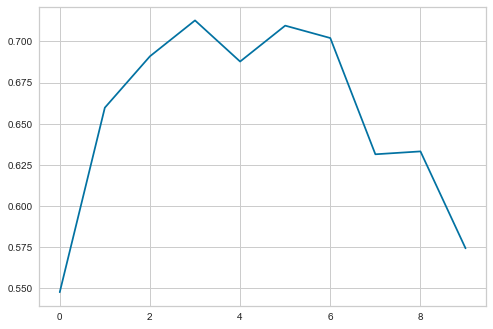

In [68]:
# # f1
# plt.plot([sfs.subsets_[i]['avg_score'] for i in list(sfs.subsets_)])

In [69]:
# indexes = []
# for i in list(sfs.subsets_):
#     for j in sfs.subsets_[i]['feature_idx']:
#         if j not in indexes:
#             indexes.append(j)

# feature_names = list(map((lambda x: eval(x)[1]), list(X_train.columns[indexes])))

In [73]:
# y_mean = [sfs.subsets_[i]['avg_score'] for i in list(sfs.subsets_)]
# metric_std = list(map((lambda x: np.std(x)), [sfs.subsets_[i]['cv_scores'] for i in list(sfs.subsets_)]))
# metric_mean = list(map((lambda x: np.mean(x)), [sfs.subsets_[i]['cv_scores'] for i in list(sfs.subsets_)]))

In [53]:
d = SFS_Graph(
        targets=['combined'],
              datasets=['c'],
              subsets=['Biomarkers + Clinical'],
              models=['randomforest'],
              selectors=['SHAP'],
)

In [54]:
figure = d.get_graph(metrics=['roc_auc'])
figure.add_annotation(text="Sequential feature selection of 10 preselected features from 'Clinical+Biomarkers C' dataset by SHAP algorithm",
                  xref="paper", yref="paper",
                  x=0.5, y=-0.1, showarrow=False)
figure.show(renderer="colab")
figure.write_image(f"{results_path}SFS-roc_auc of top SHAP features.pdf", engine="kaleido")

In [55]:
figure = d.get_graph(metrics=['f1'])
figure.add_annotation(text="Sequential feature selection of 10 preselected features from 'Clinical+Biomarkers C' dataset by SHAP algorithm",
                  xref="paper", yref="paper",
                  x=0.5, y=-0.1, showarrow=False)
figure.show(renderer="colab")
figure.write_image(f"{results_path}SFS-F1 of top SHAP features.pdf", engine="kaleido")

### Scores on 2 features: GRACE and PCSK9

In [80]:
z = Feature_selector(
            targets=['combined'],
              datasets=['c'],
              subsets=['Biomarkers + Clinical'],
              models=['randomforest'],
              selectors=['RF_feature_importance'],
)

In [81]:
X_train, X_test, y_train, y_test = z.get_train_test(link_train=link_train_combined_c, link_test=link_test_combined_c, dataset='c', subset='Biomarkers + Clinical')

In [82]:
top = list(pd.read_excel(f'./HSE project/Feature selection/combined/Biomarkers + Clinical C/RF_feature_importance/values.xlsx', header=[0], index_col=[0]).sort_values(by='values', ascending=False)['features'][:10].values)
# top 

In [ ]:
top

In [84]:
X_train = X_train[top[:2]]
X_test = X_test[top[:2]]

In [85]:

optimisation_file = pd.read_excel("./HSE project/Optimisation data/combined/Biomarkers + Clinical C/all/randomforest_optimisation.xlsx", header=[0])

model = z.get_model_instance(model='randomforest', 
                             optimisation_file=optimisation_file, 
                             X_train=X_train, 
                             y_train=y_train
                             )

In [98]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=127, n_jobs=-1,
                       random_state=10, warm_start=True)

In [102]:
predicted = model.predict_proba(X_test)
roc_auc(y_test, predicted[:, 1]).round(3)

0.853

In [101]:
predicted = model.predict(X_test)
f1(predicted, y_test).round(3)

0.588

# References

- [Guidelines and quality criteria for artificial intelligence-based prediction models in healthcare: a scoping review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8748878/pdf/41746_2021_Article_549.pdf)

- ✅ [Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5#citeas)

- ✅ [Machine learning-based prediction of adverse events
following an acute coronary syndrome (PRAISE): a modelling
study of pooled datasets](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)32519-8/fulltext)

- ✅ [Critical appraisal of artificial intelligence-based prediction models for cardiovascular disease](https://watermark.silverchair.com/ehac238.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAtQwggLQBgkqhkiG9w0BBwagggLBMIICvQIBADCCArYGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMSvd0U0E66pd-sc_vAgEQgIICh_0OOn38okwwjvtHKZZRS6iesoJ0VuLm_qXiAJTeVb_83xAfB7oneCMsGdP7SkYUZPlcO3UtImKRROpfFzoAH87-TvQu04QMni8-YL47A9k13em0EMsLU86rv0fjaSmxgG-hPnAe7eRJaEDf1ckm-YBNx65aPTx1UC8yW3YO0gDra3ROrfsyl2UariiUse8hZ5S-I2WvFx0gic__qBLni02hEetj0dt-mInD7DxKqGuk28AuNOCDlF9Q1Tfj7oSyk6_1aNHJJ9XklpOJgzsKn-j4yusaYkapojnZzcNzBGcx6tTWYDn-YFcevxsYSc_uKlSUl40oTPl5Gwp-gAyxaLx9bFRuCDA6bxfPsNjgLQR0Eo4QxBuMD5h8FR6H6hEkZ1heaEpiWvZHqwTbEMddl1L1EgD2w-L-ng1YHbegVuZLa-Noll9OWfYSsVZf330LvUYMnTSu3FxrJ72voWUNhS3xzpTvkaeTqIkQgRU5Q75TfoKpMWfefufVgDshQhRM0ww1qRImd34Faql0RyBAKOPXG_HaucEkyXb60GCd6-0yjP5Mjbq-TML0Y9pnKIvmf9wXcTw-DJTcMT97fzWbp_psY70J02wEjvHPxfkOyEl9TiA08sI24GqKHAZuSU_M5R2dGN5W7qGuN_A-TbFKvO3FyMDOgV89BtJXHk8wVYpR-f2uppZydQydht_KTHlkV8hbYf0StZGbCXLb-fk38yZ6rerF9dTXfT6PtrYdlBYrVW65ZRn1HbxhoA0LBI0f5z8gpiqQjnyxSzrX-e9FYtOfOPu-i-IfGTLMFELowQ3IXkTup2Ee1dvT0sosTfoC5Q6x6d8nubiZFtw_SLYg21vF1XH2Gw9d)

- [Interpretation of machine learning predictions for patient outcomes in electronic health records](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7153071/pdf/3200408.pdf)
- [Minimum sample size for external validation of a clinical prediction model with a binary outcome](https://pubmed.ncbi.nlm.nih.gov/34031906/)
- [Machine learning of clinical variables and coronary artery calcium scoring for the prediction of obstructive coronary artery disease on coronary computed tomography angiography: analysis from the CONFIRM registry](https://pubmed.ncbi.nlm.nih.gov/31513271/)
- [Reflection on modern methods: when worlds collide-prediction, machine learning and causal inference](https://pubmed.ncbi.nlm.nih.gov/31298274/)
- General Cardiovascular Risk Profile for Use in Primary Care

### Feature importance

- ✅ [Feature Importance May Be Lying To You](https://towardsdatascience.com/feature-importance-may-be-lying-to-you-3247cafa7ee7)
- [Different Measures of Feature Importance Behave Differently](https://hippocampus-garden.com/feature_importance/)
- [Explaining Feature Importance by example of a Random Forest](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)
- [Interpret Logistic Regression Coefficients (For Beginners)](https://quantifyinghealth.com/interpret-logistic-regression-coefficients/)

- [FAQ: HOW DO I INTERPRET ODDS RATIOS IN LOGISTIC REGRESSION?](https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/#:~:text=A%20logistic%20regression%20model%20allows,relationship%20with%20the%20predictor%20variables.)

### Imputation
I decided to use kNN imputation b/c it was easy to implement using sklearn package and it was much better than other simpler imputers. However, there are also two types of complex imputers that might be reasonable to use (MICE and datawig)
- [6 Different Ways to Compensate for Missing Values In a Dataset (Data Imputation with examples)](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779)
- [sklearn](https://scikit-learn.org/stable/modules/impute.html)
- [kNN Imputation for Missing Values in Machine Learning](https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/)


### Understanding model predictions


In paper "Critical appraisal of artificial intelligence-based prediction models for cardiovascular disease" it was mentioned the use of LIME and SHAP
  
##### LIME 
- [“Why Should I Trust You?” Explaining the Predictions of Any Classifier - paper about LIME](https://arxiv.org/pdf/1602.04938.pdf)

- [Understanding model predictions with LIME](https://towardsdatascience.com/understanding-model-predictions-with-lime-a582fdff3a3b)
- [Understanding how LIME explains predictions](https://towardsdatascience.com/understanding-how-lime-explains-predictions-d404e5d1829c)
- ✅ [How to explain ML models and feature importance with LIME?](https://analyticsindiamag.com/how-to-explain-ml-models-and-feature-importance-with-lime/)
- ✅ [Local Interpretable Model-Agnostic Explanations (LIME): An Introduction](https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/)
- ✅ [Explanations (LIME)](https://ema.drwhy.ai/LIME.html)  
##### SHAP   
- ✅ [SHAP Values Explained Exactly How You Wished Someone Explained to You](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30)
-[Using SHAP Values to Explain How Your Machine Learning Model Works](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137)
-[I have to find out what approximations they use to calculate Shapley values for all features, considering $2^n$ complexity]()
-[How to define fairness to detect and prevent discriminatory outcomes in Machine Learning](https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2)

### Fairness
- ✅ [A Tutorial on Fairness in Machine Learning](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)
- [sklego documentation](https://scikit-lego.readthedocs.io/en/latest/fairness.html)
- ✅ [Equality and fairness measures in classification models](https://www.auditingalgorithms.net/EqualityAndFairness.html)
- [Fairness Definitions Explained - должна быть понятная и полезная статья](http://fairware.cs.umass.edu/papers/Verma.pdf)
- [CS 294: Fairness in Machine Learning](https://fairmlclass.github.io/)
- []()

### Feature seletion
- ✅ [Deep-dive on ML techniques for feature selection in Python - Part 1](https://towardsdatascience.com/deep-dive-on-ml-techniques-for-feature-selection-in-python-part-1-3574269d5c69)
- ✅ [Deep-dive on ML techniques for feature selection in Python - Part 2](https://towardsdatascience.com/deep-dive-on-ml-techniques-for-feature-selection-in-python-part-2-c258f8a2ac43)
- ✅ [Deep-dive on ML techniques for feature selection in Python - Part 3](https://towardsdatascience.com/deep-dive-on-ml-techniques-for-feature-selection-in-python-part-3-de2a7593247f)
- ✅ [How to Choose a Feature Selection Method For Machine Learning](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
- ✅ [Understanding ANOVA-F for feature selection in Python](https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w#answer-74486)
- [sklearn: Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- ✅ [What are variable importance rankings useful for?](https://stats.stackexchange.com/questions/202277/what-are-variable-importance-rankings-useful-for#question-header)
- ✅ [feature importance is a slippery concept](https://stats.stackexchange.com/questions/202221/for-linear-classifiers-do-larger-coefficients-imply-more-important-features/202853#answer-202853)
- ✅ [Why lasso for feature selection?](https://stats.stackexchange.com/questions/367155/why-lasso-for-feature-selection#question-header)
- [Boruta SHAP: A Tool for Feature Selection Every Data Scientist Should Know](https://towardsdatascience.com/boruta-shap-an-amazing-tool-for-feature-selection-every-data-scientist-should-know-33a5f01285c0#:~:text=The%20idea%20of%20the%20Boruta,importance%20of%20the%20shadow%20features.)
- ✅ [Intuitions on L1 and L2 Regularisation](https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261)
- [L0 Norm, L1 Norm, L2 Norm & L-Infinity Norm](https://montjoile.medium.com/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c#:~:text=L1%20Norm%20is%20the%20sum,the%20vector%20are%20weighted%20equally.)
- []()
- []()

### Advanced predictions
- [Ensemble methods: bagging, boosting and stacking](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)
- [sklearn: Ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)
- [A Deep Dive into Stacking Ensemble Machine Learning — Part I](https://towardsdatascience.com/a-deep-dive-into-stacking-ensemble-machine-learning-part-i-10476b2ade3)
- [Cтекинг (Stacking) и блендинг (Blending)](https://dyakonov.org/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/)
- []()
- []()


### Clustering
- [Overview of Clustering Algorithms](https://towardsdatascience.com/overview-of-clustering-algorithms-27e979e3724d)
- []()
- []()